In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict

In [61]:
df=pd.read_csv("prices-split-adjusted.csv")

data=df[(df == 'AAPL').any(axis=1)]

In [62]:
apple=data[['date','close']]

In [63]:
# Convert the 'date' column to a datetime format
apple['date'] = pd.to_datetime(apple['date'])

# Set the 'date' column as the index
apple.set_index('date', inplace=True)

# Create a date range from the minimum to the maximum date in the DataFrame
date_range = pd.date_range(start=apple.index.min(), end=apple.index.max(), freq='D')

# Reindex the DataFrame with the new date range
apple = apple.reindex(date_range)

/var/folders/ny/x1j29b1n685bf0glnj5zz9qh0000gn/T/ipykernel_5128/1536378939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple['date'] = pd.to_datetime(apple['date'])


In [64]:
apple=apple.ffill(inplace=False)

In [65]:
apple

,close
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
...,...
2016-12-26,116.519997
2016-12-27,117.260002
2016-12-28,116.760002
2016-12-29,116.730003


Text(0.5, 1.0, 'Time Series Plot')

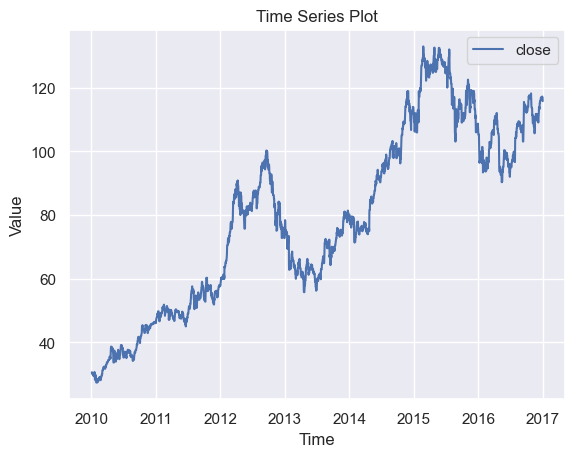

In [66]:
sns.set(style="darkgrid")  # Set a style for the plot
sns.lineplot(data=apple)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Plot")

In [67]:
kpss(apple, regression='c')

/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(6.841725587183839,
 0.01,
 30,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [68]:
kpss(apple.fillna(0), regression='ct')

/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.38137704400640904,
 0.01,
 30,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

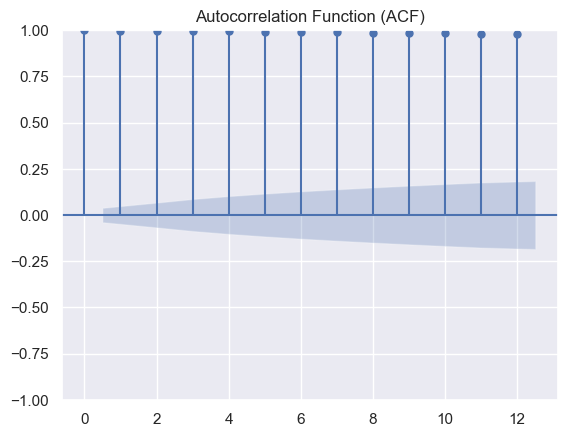

In [69]:
# Create ACF plot
plot_acf(apple, lags=12)  # 'lags' specifies the number of lags to include in the plot
plt.title('Autocorrelation Function (ACF)')
plt.show()

/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


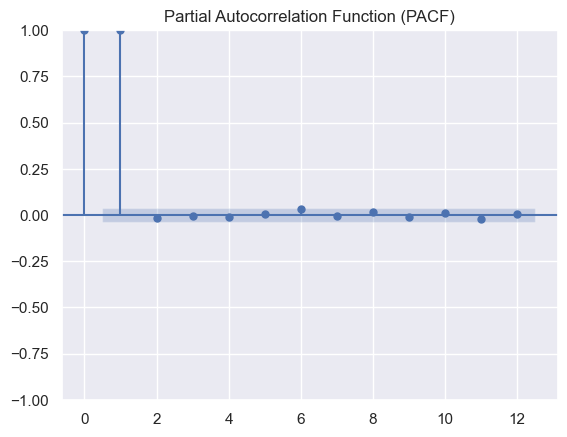

In [70]:
# Create PACF plot
plot_pacf(apple, lags=12)  # 'lags' specifies the number of lags to include in the plot
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

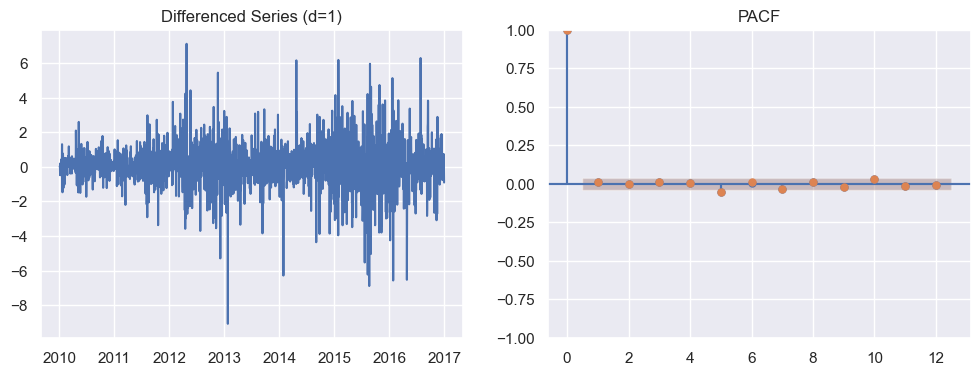

In [71]:
# Calculate the differenced series
d=1
differenced_series = apple.diff(periods=d).fillna(0)

# Plot the differenced series
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(differenced_series)
plt.title(f'Differenced Series (d={d})')

# Plot ACF and PACF
plt.subplot(122)
plot_acf(differenced_series, lags=12, ax=plt.gca(), title='ACF')
plot_pacf(differenced_series, lags=12, ax=plt.gca(), title='PACF')

plt.show()

In [72]:
# Define the split ratio (e.g., 80% for training, 20% for testing)
train_ratio = 0.7
test_ratio = 1 - train_ratio

# Alternatively, you can specify a fixed number of periods for testing
# test_period = 50  # e.g., test the last 50 time periods
# train_ratio = len(data) - test_period
# test_ratio = test_period

# Calculate the index at which to split the data
split_index = int(train_ratio * len(apple))

# Split the data into training and testing sets while keeping the row index
train_data = apple.iloc[:split_index]
test_data = apple.iloc[split_index:]

In [73]:
train_data

,close
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
...,...
2014-11-21,116.470001
2014-11-22,116.470001
2014-11-23,116.470001
2014-11-24,118.629997


Text(0.5, 1.0, 'Time Series Plot')

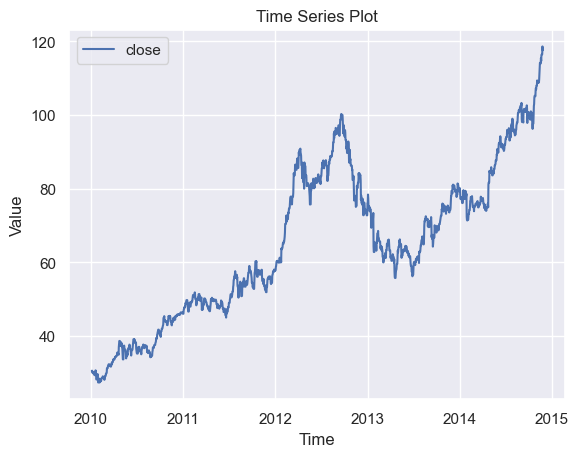

In [74]:
sns.set(style="darkgrid")  # Set a style for the plot
sns.lineplot(data=train_data)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Plot")

In [75]:
test_data

,close
2014-11-26,119.000000
2014-11-27,119.000000
2014-11-28,118.930000
2014-11-29,118.930000
2014-11-30,118.930000
...,...
2016-12-26,116.519997
2016-12-27,117.260002
2016-12-28,116.760002
2016-12-29,116.730003


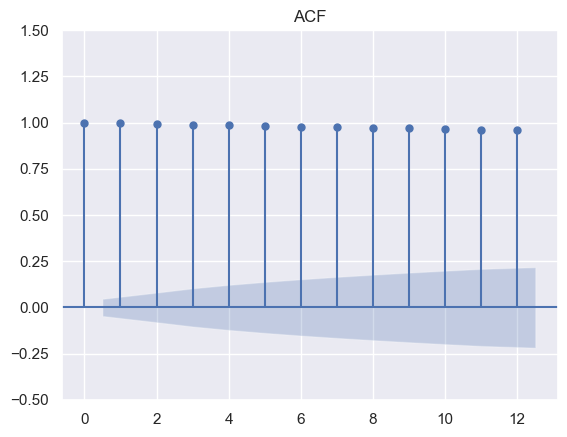

In [128]:
# Create ACF plot
fig, ax = plt.subplots()
plot_acf(train_data, lags=12, ax=ax)  # 'lags' specifies the number of lags to include in the plot
ax.set_ylim(-0.5, 1.5)  # Set the y-axis limits
plt.title('ACF')
plt.show()

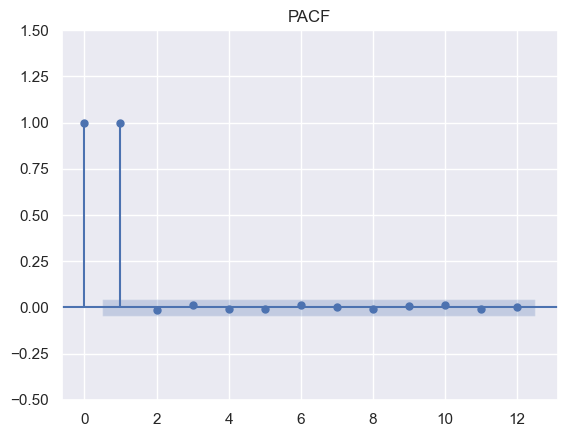

In [129]:
# Create PACF plot
fig, ax = plt.subplots()
plot_pacf(train_data, lags=12, ax=ax) # 'lags' specifies the number of lags to include in the plot
ax.set_ylim(-0.5, 1.5)
plt.title('PACF')
plt.show()

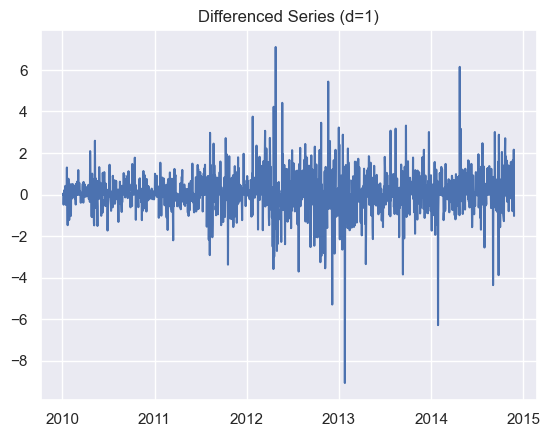

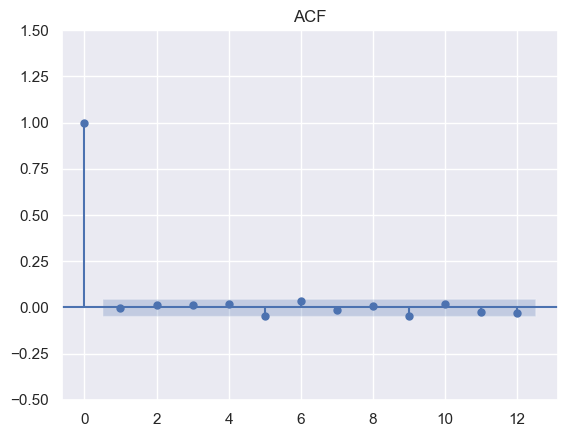

In [135]:
# Calculate the differenced series
d=1
differenced_series = train_data.diff(periods=d).fillna(0)

# Plot the differenced series

plt.plot(differenced_series)
plt.title(f'Differenced Series (d={d})')

# Plot ACF and PACF
fig, ax = plt.subplots()
plot_acf(differenced_series, lags=12, title='ACF', ax=ax)

ax.set_ylim(-0.5, 1.5)


plt.show()

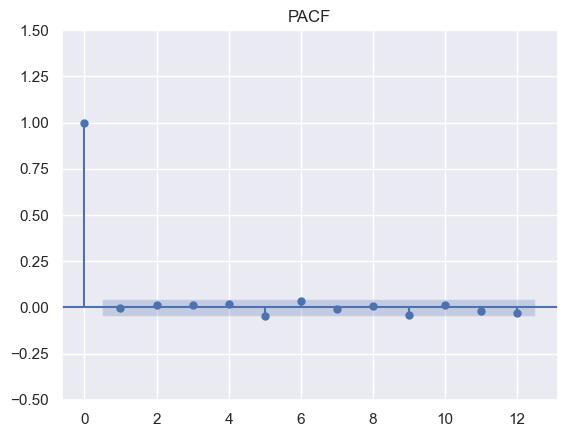

In [134]:
# Plot ACF and PACF
fig, ax = plt.subplots()
plot_pacf(differenced_series, lags=12,title='PACF',ax=ax)
ax.set_ylim(-0.5, 1.5)


plt.show()

In [84]:
p = 0  # AR order
d = 1 # Differencing order
q = 0  # MA order

arma = sm.tsa.arima.ARIMA(train_data, order=(p, d, q))
ar1ma=arma.fit()
print(ar1ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1787
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2407.379
Date:                Wed, 27 Sep 2023   AIC                           4816.758
Time:                        20:00:23   BIC                           4822.245
Sample:                    01-04-2010   HQIC                          4818.784
                         - 11-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8676      0.011     79.961      0.000       0.846       0.889
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             11563.49
Prob(Q):                              0.87   Pr

<Axes: >

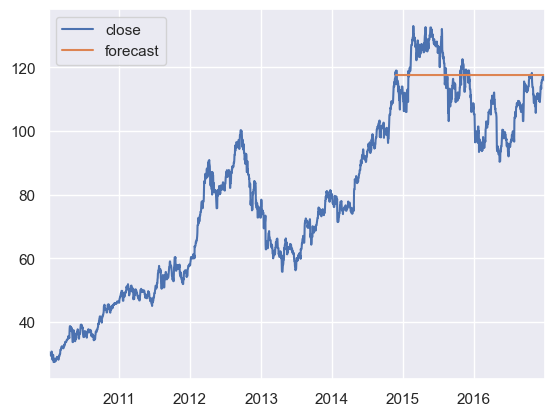

In [85]:
forecast_test = ar1ma.forecast(len(test_data))

apple['forecast'] = [None]*len(train_data) + list(forecast_test)
apple.plot()

In [86]:
train_data

,close
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
...,...
2014-11-21,116.470001
2014-11-22,116.470001
2014-11-23,116.470001
2014-11-24,118.629997


Text(0.5, 1.0, 'Time Series Plot')

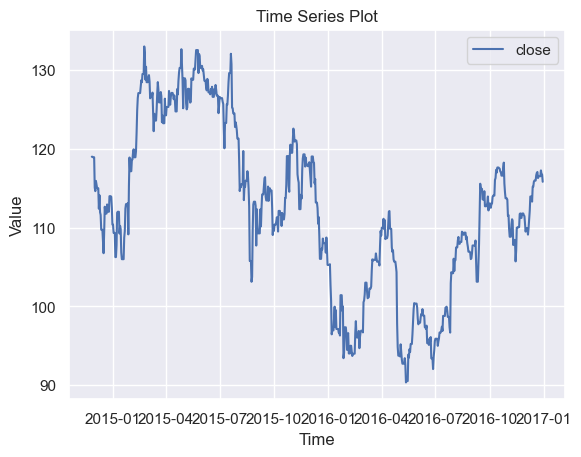

In [88]:
sns.set(style="darkgrid")  # Set a style for the plot
sns.lineplot(data=test_data)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Plot")

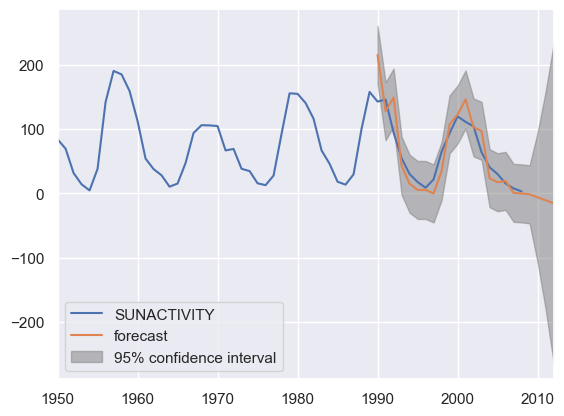

In [40]:
dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.date_range(start='1700', end='2009', freq='A')
res = sm.tsa.ARIMA(dta, order=(0,2,0)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1990', '2012', ax=ax)
plt.show()


In [49]:
dta

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


In [45]:
train_data

,close
date,
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
...,...
2014-11-18,115.470001
2014-11-19,114.669998
2014-11-20,116.309998


In [47]:
test_data.tail()

,close
date,
2016-12-23,116.519997
2016-12-27,117.260002
2016-12-28,116.760002
2016-12-29,116.730003
2016-12-30,115.820000


/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

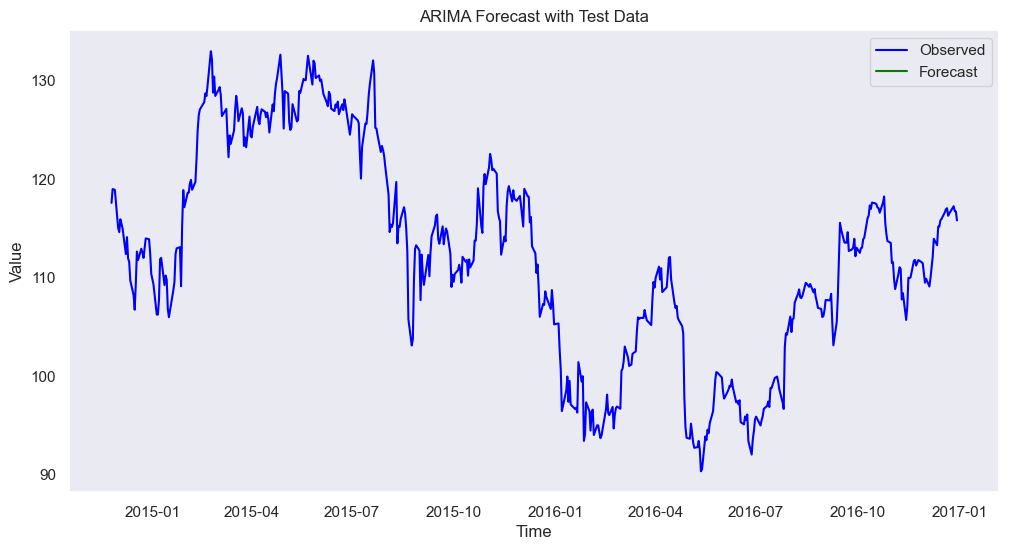

In [70]:
# Specify ARIMA order
p = 0  # AR order
d = 1  # Differencing order
q = 0  # MA order

# Fit ARIMA model to your training data['close']
ar1ma = sm.tsa.ARIMA(train_data['close'], order=(p, d, q))
ar1ma_fit = ar1ma.fit()

# Generate forecasts for the test data period
forecast_steps = 1
forecast = ar1ma_fit.forecast(steps=forecast_steps)

# Create a DataFrame with the forecasted values and date index
forecast_df = pd.DataFrame({'forecast': forecast}, index=test_data.index)

# Plot your test data['close'] and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test_data['close'], label='Observed', color='blue')
plt.plot(forecast_df, label='Forecast', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecast with Test Data')
plt.legend()
plt.grid()
plt.show()


In [136]:
# Make predictions on the training data
predicted_train = ar1ma.predict(start=0, end=len(train_data) )

# Make predictions on the test data
predicted_test = ar1ma.forecast(steps=len(test_data))

In [137]:
# Make predictions on the test data
predicted_values = ar1ma.forecast(steps=len(test_data))

# Calculate MSE using sklearn
mse = mean_squared_error(test_data['close'], predicted_test)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 141.60026412651064


In [138]:
predicted_train = ar1ma.forecast(steps=len(train_data))
# Calculate Mean Squared Error (MSE) on training data
mse_train = mean_squared_error(train_data['close'], predicted_train)
mse_train

3171.3622073839842

In [141]:
predicted_train 

2014-11-26    117.599998
2014-11-27    117.599998
2014-11-28    117.599998
2014-11-29    117.599998
2014-11-30    117.599998
                 ...    
2019-10-13    117.599998
2019-10-14    117.599998
2019-10-15    117.599998
2019-10-16    117.599998
2019-10-17    117.599998
Freq: D, Name: predicted_mean, Length: 1787, dtype: float64

In [ ]:
fig, ax = plt.subplots()
ax = train_data.loc['2010-01-04':].plot(ax=ax, label='Training Data')
plot_predict(ar1ma, '2014-11-26' ,'2016-12-30', ax=ax,color='red', label='Predictions')
sns.lineplot(data=test_data)

# Add a legend to the top-left corner
ax.legend(loc='upper left')

plt.show()

In [139]:
# Residuals
residuals = ar1ma.resid

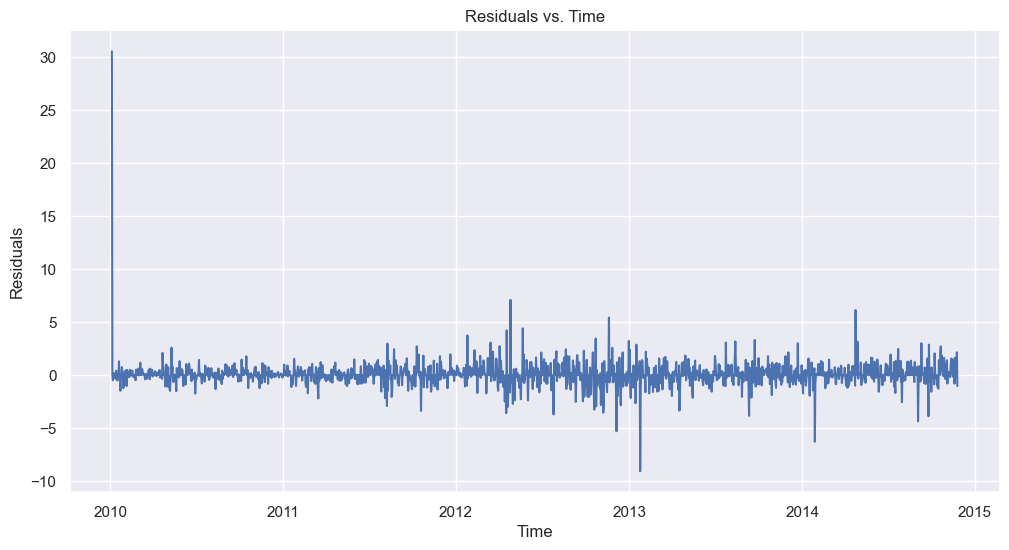

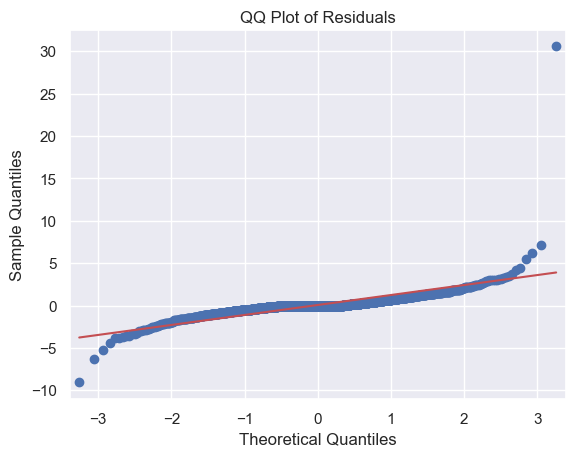

In [140]:
# Residuals vs. Time Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, residuals)
plt.title('Residuals vs. Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# QQ Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

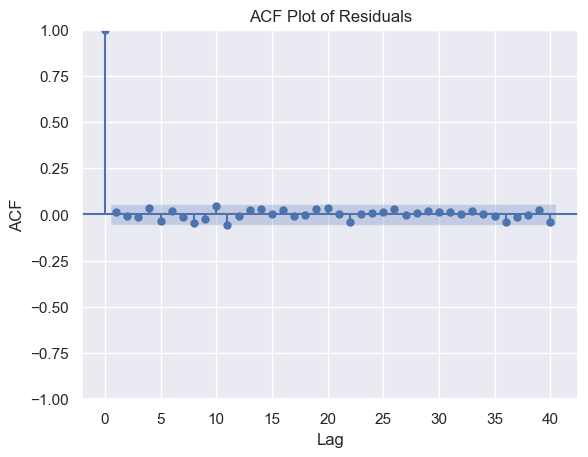

/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


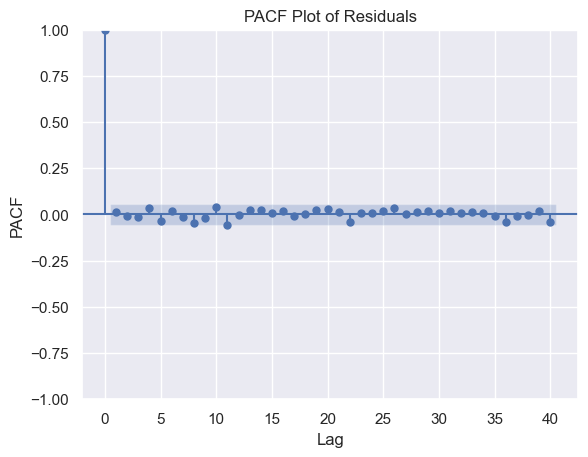

In [83]:
# ACF (Auto-Correlation Function) Plot of Residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# PACF (Partial Auto-Correlation Function) Plot of Residuals
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.title('PACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [31]:
# Perform the Ljung-Box test on the residuals
# Set lags parameter to the maximum lag you want to test
lags = 20  # Adjust as needed
test_results = acorr_ljungbox(residuals, lags=lags)

In [85]:
p_values = test_results.lb_pvalue

ValueError: x and y must have same first dimension, but have shapes (766,) and (1787,)

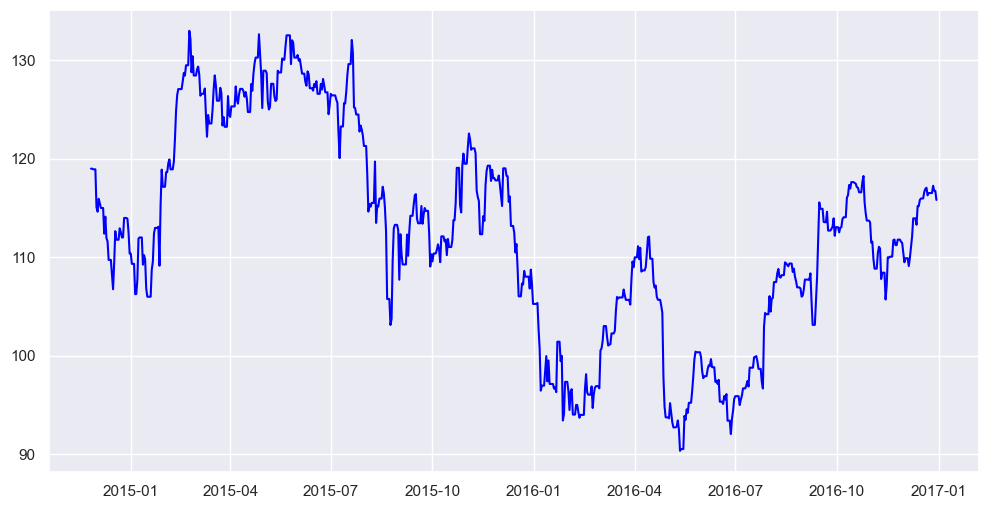

In [143]:
# Create a time index for the test data
time_index = test_data.index

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, test_data, label='Actual', color='blue')
plt.plot(time_index, predicted_train , label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecasting Plot')
plt.legend()
plt.grid()
plt.show()

In [68]:
p = 0  # AR order
d = 0 # Differencing order
q = 1  # MA order

ma1 = sm.tsa.arima.ARIMA(train_data['close'], order=(p, d, q))
ma01=ma1.fit()
ma01.summary()

/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1233
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -4691.242
Date:                Wed, 27 Sep 2023   AIC                           9388.484
Time:                        13:14:29   BIC                           9403.835
Sample:                             0   HQIC                          9394.259
                               - 1233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.2675      0.613    106.402      0.000      64.065      66.470
ma.L1          0.9602      0.010     92.716      0.000       0.940       0.980
sigma2       117.8536      6.431     18.327      0.000     105.250     130.458
===================================================================================
Ljung-Box (L1) (Q):                1022.05   Jarque-Bera (JB):                45.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# Residuals
residuals = ma01.resid

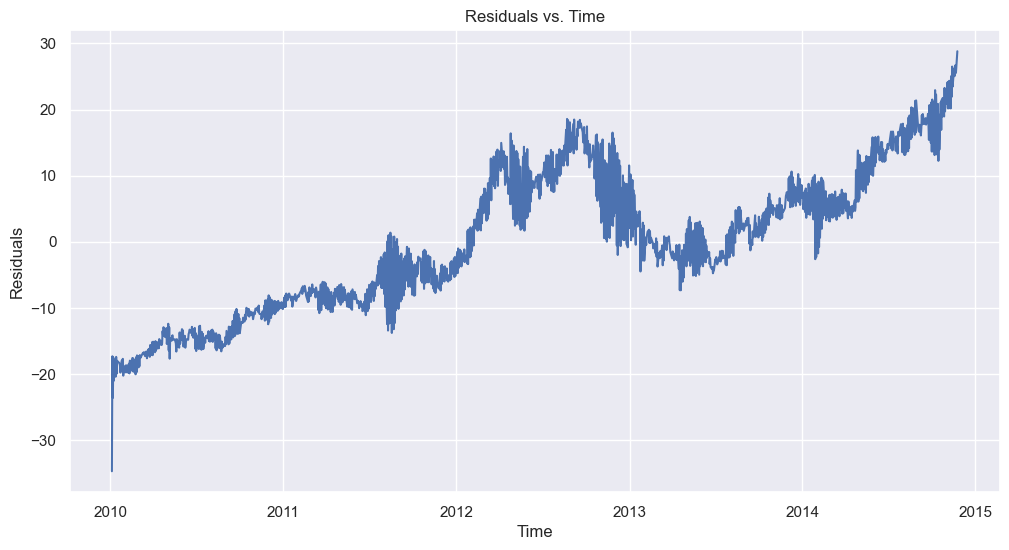

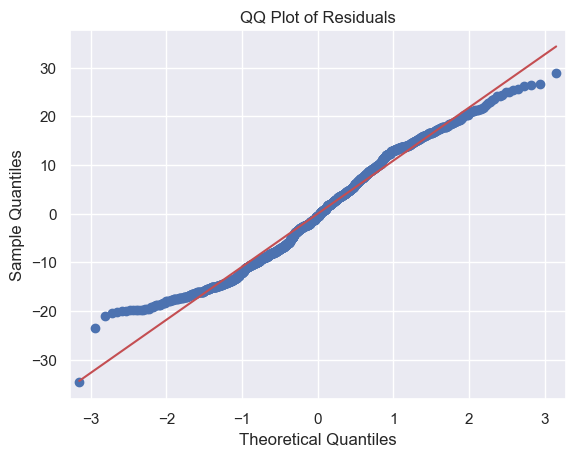

In [70]:
# Residuals vs. Time Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, residuals)
plt.title('Residuals vs. Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# QQ Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

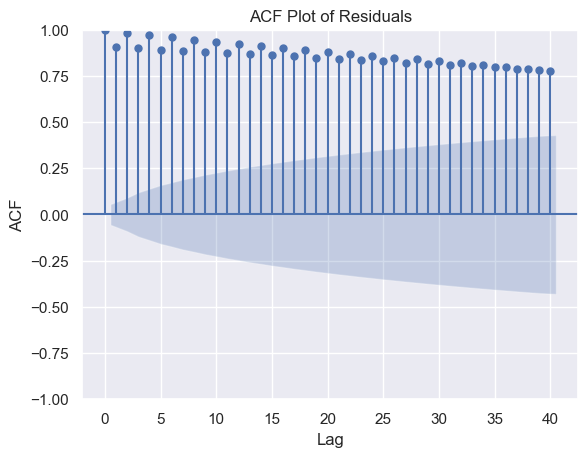

/Users/katie/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


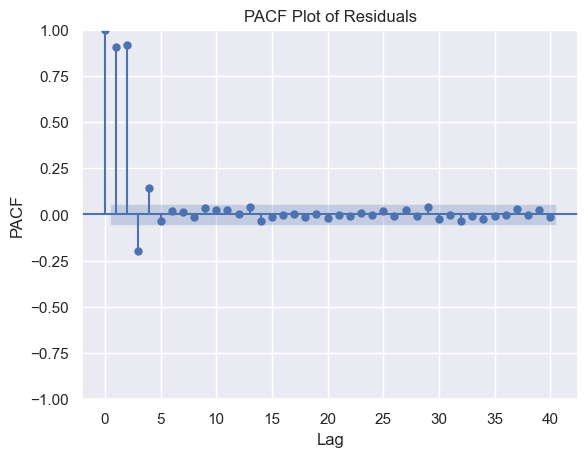

In [71]:
# ACF (Auto-Correlation Function) Plot of Residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# PACF (Partial Auto-Correlation Function) Plot of Residuals
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.title('PACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [72]:
# Perform the Ljung-Box test on the residuals
# Set lags parameter to the maximum lag you want to test
lags = 20  # Adjust as needed
test_results = acorr_ljungbox(residuals, lags=lags)

test_results

,lb_stat,lb_pvalue
1,1017.752081,2.486778e-223
2,2215.493586,0.000000e+00
3,3217.090591,0.000000e+00
4,4385.499745,0.000000e+00
5,5372.284160,0.000000e+00
6,6512.345021,0.000000e+00
7,7485.214864,0.000000e+00
8,8597.578015,0.000000e+00
9,9557.650030,0.000000e+00
10,10645.840572,0.000000e+00


In [75]:
p_values = test_results.lb_pvalue

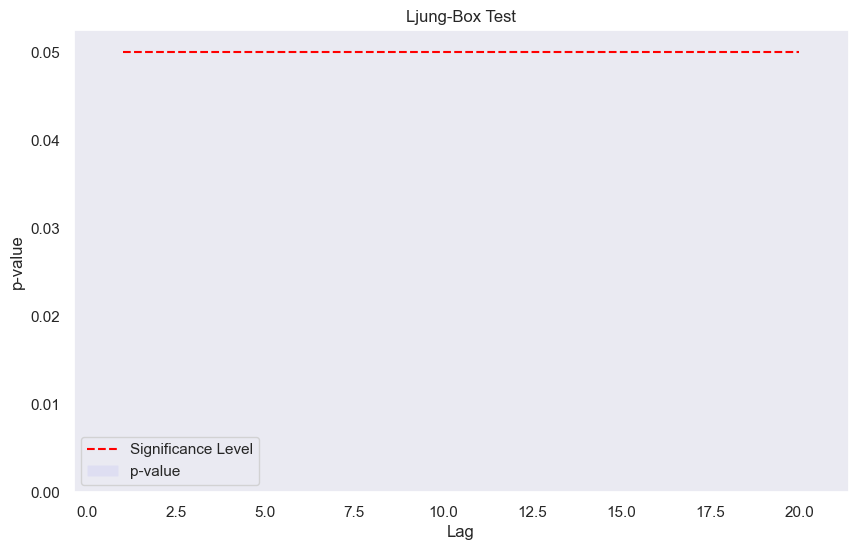

In [77]:
# Create a Ljung-Box plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, lags + 1), p_values, color='blue', alpha=0.7, label='p-value')
plt.plot(range(1, lags + 1), significance_line, color='red', linestyle='--', label='Significance Level')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Ljung-Box Test')
plt.legend()
plt.grid()
plt.show()